In [1]:
from keras.layers import Embedding, Dense, LSTM, Dropout, Input, Bidirectional
from keras.layers import GRU, MaxPooling1D, Conv1D, Flatten
from keras.preprocessing import text, sequence
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import Callback

from gensim.models.keyedvectors import KeyedVectors

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from utils import *

Using TensorFlow backend.


In [2]:
# language model
WORD_MODEL, _, MAX_FEATURES, EMBED_SIZE = get_init_parameters('./arabic_bins/web_cbow_300')

# load data
data_paths = ['arabic_dataset_classifiction.csv']
x_train, x_test, y_train, y_test, MAX_TEXT_LENGTH = split_datasets(data_paths, test_size=0.1)
CLASSES_LIST = np.unique(y_train)
print('Label categories: ' + str(CLASSES_LIST))

# 
x_train, x_test, y_train, y_test, train_y_cat, word_index = class_str_2_ind(x_train, x_test, 
                                                                            y_train, y_test,
                                                                            CLASSES_LIST, MAX_FEATURES,
                                                                            MAX_TEXT_LENGTH)

Dataset splited.
Label categories: ['0' '1' '2' '3' '4']
Converting data to trainable form...
Number of training examples: 100555
Number of testing examples: 11173


In [3]:
test_cat_y = np_utils.to_categorical(y_test, len(CLASSES_LIST))

Try less timesteps

In [4]:
MAX_TEXT_LENGTH

5049

In [5]:
# CHANGE MAX LENGTH (timesteps)
MAX_TEXT_LENGTH = 2000

In [6]:
def get_model(embedding_weights, word_index, vocab_dim, max_length, print_summary=True):
    inp = Input(shape=(max_length,))
    model = Embedding(input_dim=len(word_index)+1,
                      output_dim=vocab_dim,
                      trainable=False,
                      weights=[embedding_weights])(inp)

    model = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(model)
    model = MaxPooling1D(pool_size=2)(model)
    model = Flatten()(model)
    model = Dropout(0.1)(model)
    model = Dense(200, activation='relu')(model)
    model = Dropout(0.1)(model)
    model = Dense(5, activation='softmax')(model)
    model = Model(inputs=inp, outputs=model)
    
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    if print_summary:
        model.summary()
    return model


def get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH):
    tmp = get_embedding_matrix(word_index, WORD_MODEL, EMBED_SIZE)
    model = get_model(tmp, word_index, EMBED_SIZE, MAX_TEXT_LENGTH, print_summary=True)
    return model


class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

def train_fit_predict(model, x_train, x_test, y_train, y_test, batch_size, epochs, TestCallback=TestCallback):
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs, verbose=1,
                        validation_data=(x_test, y_test))
                        #callbacks=[TestCallback((x_test, y_test))])
    #score = model.predict(x_test)
    #return history, score, model
    return history, model

In [7]:
model = get_main_model(word_index, WORD_MODEL, EMBED_SIZE, MAX_TEXT_LENGTH)

Building embedding matrix...
Embedding matrix built.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 2000, 300)         121346400 
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2000, 32)          48032     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1000, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)        

In [ ]:
del WORD_MODEL
del word_index

In [8]:
import time

time_start = time.time()
history, model = train_fit_predict(model,
                                   x_train[:, :MAX_TEXT_LENGTH], 
                                   x_test[:, :MAX_TEXT_LENGTH],
                                   train_y_cat, test_cat_y,
                                   batch_size=100, epochs=10)
time_start = time.time() - time_start
print("Took : "+str(np.round(time_start, 2))+" (s)")

Train on 100555 samples, validate on 11173 samples
Epoch 1/10
100555/100555 [==============================] - 18s 180us/step - loss: 0.4047 - acc: 0.8748 - val_loss: 0.2496 - val_acc: 0.9291
Epoch 2/10
100555/100555 [==============================] - 17s 172us/step - loss: 0.2188 - acc: 0.9387 - val_loss: 0.2321 - val_acc: 0.9324
Epoch 3/10
100555/100555 [==============================] - 17s 172us/step - loss: 0.1826 - acc: 0.9491 - val_loss: 0.2208 - val_acc: 0.9366
Epoch 4/10
100555/100555 [==============================] - 17s 173us/step - loss: 0.1554 - acc: 0.9567 - val_loss: 0.2137 - val_acc: 0.9368
Epoch 5/10
100555/100555 [==============================] - 17s 173us/step - loss: 0.1329 - acc: 0.9626 - val_loss: 0.2101 - val_acc: 0.9388
Epoch 6/10
100555/100555 [==============================] - 17s 173us/step - loss: 0.1131 - acc: 0.9677 - val_loss: 0.2111 - val_acc: 0.9391
Epoch 7/10
100555/100555 [==============================] - 17s 173us/step - loss: 0.0979 - acc: 0.9720

In [12]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'val_acc', 'acc'])

In [13]:
model.evaluate(x_test[:, :MAX_TEXT_LENGTH], test_cat_y)

11173/11173 [==============================] - 1s 120us/step


[0.22283835926217443, 0.9390494943166562]

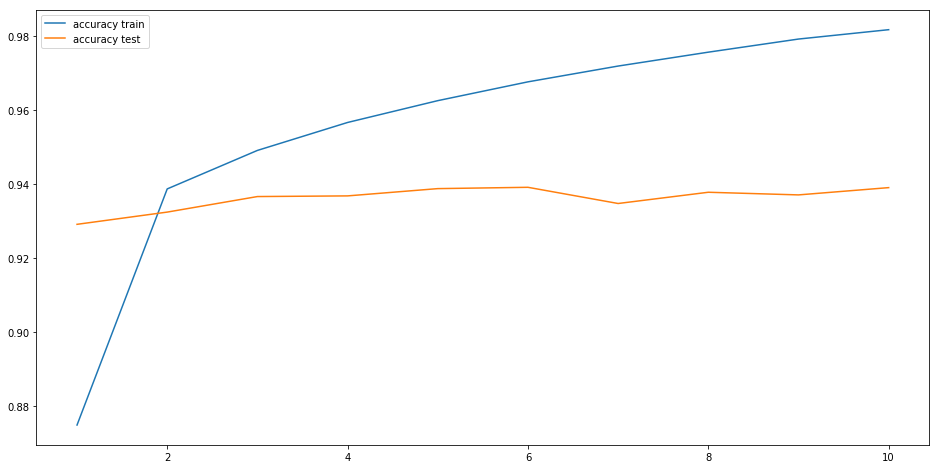

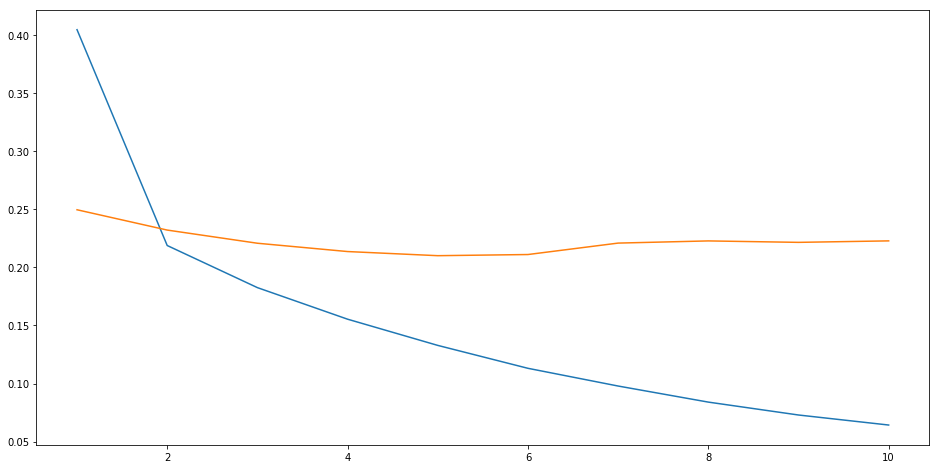

In [11]:
import matplotlib.pyplot as plt

plt.figure(num=1, figsize=(16, 8))
plt.plot(range(1, len(history.history['acc'])+1), history.history['acc'], label="accuracy train")
plt.plot(range(1, len(history.history['val_acc'])+1), history.history['val_acc'], label="accuracy test")
plt.legend()

plt.figure(num=2, figsize=(16, 8))
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label="loss")
plt.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label="loss test")